# What Is NLP?
Natural Language Processing (NLP) is a set of methods for extracting information from text. But is text not already data and what would we extract? It is data, however it is represented as a continuous string of text like the one you are reading right now. The issue here is that statistics use numbers as input. So how do we make numbers out of text? Usually we break down the text into words. We can then one-hot encode the words and build a binary matrix. The columns of the matrix are the tokens, while the rows are the texts. We can then use the binary matrix as input to a range of numeric functions.

# Tokenization
Let us download a dataset of news articles from 20 newsgroups.

In [1]:
from sklearn.datasets import fetch_20newsgroups
news = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

We can select a single news article and print its contents:

In [2]:
print(news.data[0])



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [3]:
news.data[0][-45:]

'\nregular season game.          PENS RULE!!!\n\n'

In [4]:
news.data[0].split()[-5:]

['regular', 'season', 'game.', 'PENS', 'RULE!!!']

However, note that the `game.` token also includes the punctuation at the end. The `RULE!!!` token is capitalized and includes the punctuation. Capitalization carries its own set of problems as it can make several distinct tokens out of the same sema. We could turn to another basic method for splitting text - regular expressions:

In [5]:
import re

In [6]:
def tokenize_regex(regex, text):
    return [t.lower() for t in re.split(regex, text) if t != '']

In [7]:
punct_whitesp = re.compile(r'\s|[\.\(\)\?\!]+')
tokenize_regex(punct_whitesp, news.data[0])[-5:]

['regular', 'season', 'game', 'pens', 'rule']

That looks even better. Note that we also made all tokens in lowercase such that `RULE` will match with `rule`. However, in reality, texts are rarely so clean. They contain:

* Special characters;
* Random new lines, tabs or other whitespace characters;
* Improperly scanned characters (e.g. '§' instead of 'S');
* Foreign words;
* Tpyos;

That's why an extensive work must be performed to clean the text and tokenize it. The tokenization methods may also differ depending on the subject matter, the types of texts and the quantity of documents. Sometimes this task constitutes the bulk of the NLP work.

# Stemming
look at the following tokens: `go`, `going`. They represent different strings, but have the same meaning. What can we do about this?

In [9]:
import nltk

In [10]:
porter = nltk.PorterStemmer()
for token in ['go', 'going']:
    print(f'The initial for is: {token}, but after stemming, it becomes: {porter.stem(token)}')

The initial for is: go, but after stemming, it becomes: go
The initial for is: going, but after stemming, it becomes: go


We can use this technique for text normalization if we want to focus on the meaning rather than the morphology of the text. The usefulness of the stemming technique is proportional to the text size and the morphological complexity.

# One-Hot Encoding
We can take our news dataset and build a matrix. The rows of the matrix will represent the various news articles, while the columns will represent a one-hot encoding of all the tokens for all news articles.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [17]:
count_vectorizer = CountVectorizer(# ngram_range=(1, 1),
                                   token_pattern = r'[A-z]+',
                                   # strip_accents='ascii',
                                   # lowercase=True,
                                   stop_words='english',
                                   min_df=2)

In [18]:
vectorized_text = count_vectorizer.fit_transform(news.data)

In [19]:
first_article = pd.DataFrame(vectorized_text.getrow(0).todense(0), columns=count_vectorizer.get_feature_names()).loc[0]

Let us look at the top 10 tokens from the news article:

In [20]:
import matplotlib.pyplot as plt

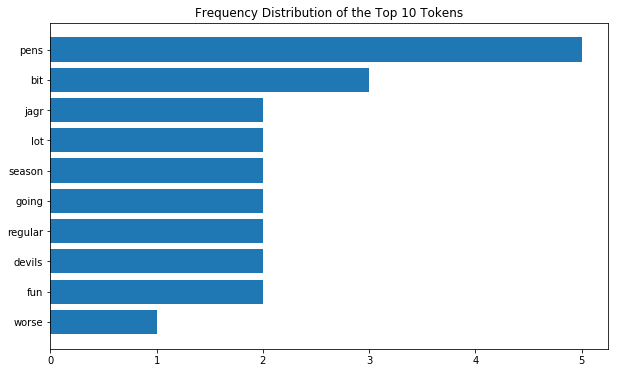

In [21]:
to_plot = first_article[first_article >= 1].sort_values()[-10:]
fig = plt.figure(figsize=(10, 6))
plt.barh(to_plot.index, to_plot.values)
plt.title('Frequency Distribution of the Top 10 Tokens')
plt.show()

As we can see, we can gain some insight from the most frequent terms in a text: `pens`, `jagr` and `season` imply that the article is about a sports match. In addition, we can also derive the literary complexity of the text by dividing the total number of tokens by the number of unique tokens. Our intuition here is that different genres of texts have different literary complexities (e.g. a simple note has a different complexity than a science article).

In [22]:
to_plot = first_article[first_article >= 1]
print(f'The literary complexity of the article is: {(1 - (len(to_plot) / to_plot.sum())):0.2%}')

The literary complexity of the article is: 20.31%


In [23]:
# plt.plot(x, y, "b|", scalex=0.1)
# plt.yticks(list(range(len(words))), words, color="b")
# plt.ylim(-1, len(words))
# plt.title('Dispersion Plot')
# plt.xlabel("Word Offset")
# plt.show()

# TFIDF
Suppose we have a group of texts. We want to figure out what are the important terms in each text. That will allow us to infer what the text is about. How can we achieve that? Intuition tells us that terms that are generally rare throughout a corpus (a group of texts), but are frequent in a particular text could be the most important. We can express this intuition as:

$tfidf(t, d, D) = tf(t, d) idf(t, D)$

Where $tf(t, d)$ is the term frequency for a single document. It is defined as:

$tf(t, d) = 0.5 + 0.5\frac{f(t, d)}{max \{f_{t', d} : t' \in d \}}$

The inverse corpus document frequency $idf(t, D)$ is defined as:

$idf(t, D) =  log \frac{N}{|\{d \in D : t \ d\}|}$

Hence the etymology of the name - term frequency inverse document frequency (TFIDF). Let's apply this method to our text:

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [25]:
tfidf_transformer = TfidfTransformer()
# tfidf_transformer = TfidfVectorizer(# ngram_range=(1, 2),
#                                     token_pattern = r'[A-z]+',
#                                     # strip_accents='ascii',
#                                     # lowercase=True,
#                                     stop_words='english',
#                                     # max_features=int(1e4),
#                                     # max_df=0.7,
#                                     min_df=2)

In [26]:
tfidf = tfidf_transformer.fit_transform(vectorized_text)
# tfidf = tfidf_transformer.fit_transform(news.data)

We can now show the 3 most important terms for each text:

In [27]:
from collections import defaultdict
tfidf_result = defaultdict(list)

top_n = 3

for i, line in enumerate(news.data[:5]):
    tfidf_result['doc'].append(line)
    for j in range(top_n):
        feature_names = count_vectorizer.get_feature_names()
        # feature_names = tfidf_transformer.get_feature_names()
        term_df = test_df = pd.DataFrame(tfidf.getrow(i).todense(),
                                         columns=feature_names)
        term = term_df.loc[0].sort_values(ascending=False).reset_index()
        tfidf_result[f'term_{j+1}'].append(term.loc[j].values[0])
        tfidf_result[f'importance_{j+1}'].append(term.loc[j].values[1])

In [28]:
pd.DataFrame(tfidf_result)

,doc,term_1,importance_1,term_2,importance_2,term_3,importance_3
0,\n\nI am sure some bashers of Pens fans are pr...,pens,0.548249,jagr,0.250491,devils,0.218444
1,My brother is in the market for a high-perform...,pro,0.306293,bus,0.301722,performance,0.291752
2,\n\n\n\n\tFinally you said what you dream abou...,azerbadjan,0.368957,weapons,0.290132,armenians,0.240284
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,bus,0.411414,transfers,0.379786,scsi,0.349866
4,1) I have an old Jasmine drive which I cann...,jasmine,0.421156,inexpensive,0.329055,drive,0.291421


That is an even better way to gain insight into the semantics of each text. Let us look at our original example (the article about the sports match). In this case, the 3 most important terms are `pens`, `jagr` and `devils` - the names of the competing teams and the university to which the host belongs. This is a much better result than the one achieved by simple term frequency.

We can use the importance of the tokens from all texts in order to group them by semantics. This will allow us to see articles belonging to the same category or topic.

# K-Means Clustering
We can use an unsupervised learning algorithm to automatically group texts by their meaning.

In [29]:
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

In [30]:
clusterer = MiniBatchKMeans(n_clusters=len(news.target_names), init='k-means++', n_init=4, init_size=1000, batch_size=1000, verbose=False, random_state=42)

In [31]:
clusterer.fit(tfidf)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=20,
        n_init=4, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=False)

In [32]:
print(f'Homogeneity: {metrics.homogeneity_score(news.target, clusterer.labels_):.2%}')
print(f'Completeness: {metrics.completeness_score(news.target, clusterer.labels_):.2%}')
print(f'V-measure: {metrics.v_measure_score(news.target, clusterer.labels_):.2%}')
print(f'Adjusted Rand-Index: {metrics.adjusted_rand_score(news.target, clusterer.labels_):.2%}')
print(f'Silhouette Coefficient: {metrics.silhouette_score(tfidf, clusterer.labels_, sample_size=10000):.2%}')

Homogeneity: 21.28%
Completeness: 30.39%
V-measure: 25.03%
Adjusted Rand-Index: 3.48%
Silhouette Coefficient: 0.74%


Here is a visualization of the various clusters of articles:

In [33]:
normalizer = Normalizer()
svd = TruncatedSVD(n_components=2)
tfidf_2d = svd.fit_transform(tfidf)
# tfidf_2d = normalizer.fit_transform(tfidf_2d)

In [168]:
tfidf_2d_df = pd.DataFrame(tfidf_2d)
tfidf_2d_df.rename(columns={0: 'x', 1: 'y'}, inplace=True)
tfidf_2d_df['cluster'] = clusterer.labels_
tfidf_2d_df['text'] = [text[:100] for text in news.data]

In [169]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CategoricalColorMapper
from bokeh.palettes import plasma, d3, brewer
from bokeh.plotting import figure
from bokeh.transform import transform


palette_colors = brewer['Spectral'][11]
to_plot = tfidf_2d_df[tfidf_2d_df.cluster.isin(range(11))]

colormap = {i: palette_colors[i] for i in to_plot.cluster.unique()}
colors = [colormap[x] for x in to_plot.cluster]

source = ColumnDataSource(data=dict(x=to_plot.x, y=to_plot.y, desc=to_plot.text, color=colors))
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("(x,y)", "(@x, @y)"),
    ('desc', '@desc'),
])

p = figure(plot_width=600, plot_height=400, tools=[hover, 'pan', 'wheel_zoom', 'reset'], title='test')
p.circle('x', 'y', size=5, color='color', source=source)

output_notebook()
show(p)

Loading BokehJS ...

# Supervised Learning With Naive Bayes
In case, we have the category of the news articles, we can train a model to predict it. The input data for the model will be the TFIDF result. The importance of each term in the sparse matrix will be the predictor for the category of the article. To achieve that, we will use an algorithmic implementation of the Bayes theorem, namely the Multinomial Naive Bayes algorithm.

In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [41]:
classifier = MultinomialNB(alpha=0.2)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, news.target, test_size=0.25, random_state=42, stratify=news.target)

In [43]:
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)

In [44]:
print(f'F1 score: {metrics.f1_score(y_test, classifier.predict(X_test), average="weighted"):.2%}')

F1 score: 74.49%


In [45]:
news_categories = pd.DataFrame(news.data, columns=['article'])
news_categories['actual'] = news.target
news_categories['predicted'] = classifier.predict(tfidf)
news_categories['acrual_name'] = [news.target_names[category] for category in news_categories.actual]
news_categories['predicted_name'] = [news.target_names[category] for category in news_categories.predicted]

In [46]:
news_categories.head()

,article,actual,predicted,acrual_name,predicted_name
0,\n\nI am sure some bashers of Pens fans are pr...,10,10,rec.sport.hockey,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,3,comp.sys.ibm.pc.hardware,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,17,talk.politics.mideast,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,3,comp.sys.ibm.pc.hardware,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,4,comp.sys.mac.hardware,comp.sys.mac.hardware


# Word2Vec
Word2Vec is a word embedding model that calculates the probability of a certain token being preceded or followed by a range of other tokens. The assumption is that positional co-occurrence is proportional to semantic relatedness (the so called 'distributional hypothesis'). The model itself represents each token as a vector of the probability of it being close to every other token in the entire dictionary of the corpus. We can then use the word vectors in their mathematical context. We can calculate the similarity between two words by taking the cosine of the angle between the corresponding vectors. We can calculate relationships between two terms and find the equivalent relationship in a third one by using vector subtraction.

To demonstrate that, we will train a Word2Vec model on all articles related to computers. We will then see if the relationships between the terms in that context match our intuition. We will start by locating all news articles from the categories: `comp.os.ms-windows.misc`, `comp.sys.ibm.pc.hardware`, `comp.sys.mac.hardware`, `comp.windows.x`, `sci.electronics`.

In [47]:
import gensim
from nltk import word_tokenize

In [48]:
all_news = pd.DataFrame(news.data, columns=['article'])
all_news['category'] = news.target
all_news['category_name'] = [news.target_names[category] for category in all_news.category]

In [49]:
news.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [99]:
computer_news_categories = ['comp.os.ms-windows.misc',
                            'comp.sys.ibm.pc.hardware',
                            'comp.sys.mac.hardware',
                            'comp.windows.x',
                            'sci.electronics']
computer_news = all_news[all_news.category_name.isin(computer_news_categories)]

In [100]:
tokenized_news = [word_tokenize(article) for article in computer_news.article]

In [101]:
print(f'The total number of computer news articles is: {len(tokenized_news)}')

The total number of computer news articles is: 4902


The number of articles is certainly limited, but nevertheless we can try and see the results of the model. We will investigate the results of the model for the relationships between several computer and electronics terms. Note that `mouse` and `tower` have different meanings in different contexts of the English language. Since we have trained our algorithm on technical articles, we expect the meaning of those terms to be the one related to computer technology.

In [102]:
word2vec = gensim.models.Word2Vec(tokenized_news, seed=42)

In [121]:
word2vec.wv.most_similar(positive=['harddrive', 'memory'], negative=['cpu'], topn=1)

[('space', 0.8666731119155884)]

In [104]:
word2vec.wv.most_similar(positive=['keyboard', 'mouse'], negative=['display'], topn=1)

[('computer', 0.8556392192840576)]

In [109]:
word2vec.wv.most_similar(positive=['mouse', 'hardware'], negative=['routine'], topn=1)

[('software', 0.8267754316329956)]

In [106]:
word2vec.wv.doesnt_match(['harddrive', 'keyboard', 'os', 'tower'])

'keyboard'

In [107]:
term1 = 'mouse'
term2 = 'keyboard'
print(f'The similarity between {term1} and {term2} is: {word2vec.wv.similarity(term1, term2):.2%}')

The similarity between mouse and keyboard is: 89.60%
